In [1]:
%matplotlib notebook
import SimpleITK as sitk
import numpy as np
import sys
import os
import gui
import copy
OUTPUT_DIR = 'Output'
from ipywidgets import interact, fixed
from IPython.display import display, HTML
import registration_callbacks
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
from registration_utilities import registration_errors
from gui import PairedPointDataManipulation, display_errors
from ipywidgets import interact, fixed
from IPython.display import clear_output

In [5]:


# İki resmin görüntü yığınları arasında etkileşimli olarak görüntülenmesi
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):

    plt.imsave("fixed_image_z.jpeg",fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r)
    plt.imsave("moving_image_z.jpeg",moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r)

    
    # İki alt grafik ve belirtilen boyutta bir şekil oluşturma.
    plt.subplots(1,2,figsize=(10,8))
    
    # Sabit resmi ilk alt grafikte çizilmesi
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Registration uygulanacak resmin grafikte çizilmesi
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

#  Aynı fiziksel alanı kaplayan iki görüntünün bir görüntü yığınının alfa harmanlamasını kaydırmak 
# ve değiştirmek için IPython etkileşim yöntemi tarafından çağrılan geri arama.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.imsave("result1.jpeg",sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r)
    

       
    print(sitk.GetArrayViewFromImage(img).shape)
    plt.show()
    
# StartEvent gerçekleştiğinde geri çağırma başlatılır, yeni verilerimizi ayarlar.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Verilerin temizlenmesi
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    plt.close()

# Verilerin Güncellenmesi
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    clear_output(wait=True)
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Metric değerlerinin güncellenmesi
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [6]:

# Görüntüleri kaydet
def save_transform_and_image(transform, fixed_image, moving_image, outputfile_prefix):
                            
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
       
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(transform)
    sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix+'.mha')
    sitk.WriteTransform(transform, outputfile_prefix+'.tfm')

# Kayıt için kullanılacak iki seriyi seçen dropbox'tan geri arama.    
def DICOM_series_dropdown_callback(fixed_image, moving_image, series_dictionary):

    global selected_series_fixed
    global selected_series_moving
    
    img_fixed = sitk.ReadImage(series_dictionary[fixed_image][0])
    img_moving = sitk.ReadImage(series_dictionary[moving_image][0])
    
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0031' : 'Series time:',
                     '0008|0070' : 'Manufacturer: '}
    html_table = []
    html_table.append('<table><tr><td><b>Tag</b></td><td><b>Fixed Image</b></td><td><b>Moving Image</b></td></tr>')
    for tag in tags_to_print:
        fixed_tag = ''
        moving_tag = ''
        try:            
            fixed_tag = img_fixed.GetMetaData(tag)
        except: 
            pass
        try:            
            moving_tag = img_moving.GetMetaData(tag)
        except:
            pass           
        html_table.append('<tr><td>' + tags_to_print[tag] + 
                          '</td><td>' + fixed_tag + 
                          '</td><td>' + moving_tag + '</td></tr>')
    html_table.append('</table>')
    display(HTML(''.join(html_table)))
    selected_series_fixed = fixed_image
    selected_series_moving = moving_image 

In [7]:
# Verileri okuma

data_directory = 'A:/BitirmeProjesi/DataSet/2_09_P'
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)

series_files_names = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory,series_IDs[0])
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_files_names)
fixed_image = sitk.ReadImage(series_reader.GetGDCMSeriesFileNames(data_directory, series_IDs[0]), sitk.sitkFloat32)
series_files_names = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory,series_IDs[1])
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_files_names)
moving_image = sitk.ReadImage(series_reader.GetGDCMSeriesFileNames(data_directory, series_IDs[1]), sitk.sitkFloat32)

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));


interactive(children=(IntSlider(value=51, description='fixed_image_z', max=103), IntSlider(value=63, descripti…

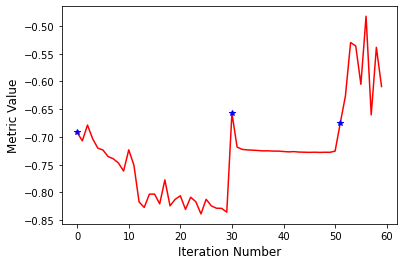

In [10]:
# Transformation İşlemi
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())


registration_method = sitk.ImageRegistrationMethod()

# Similarity metric İşlemleri
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizasyon İşlemleri.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Çoklu çözünürlük çerçevesi için kurulum.           
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# İlk transformu tekrarlama
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Metric Grafiği
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))


In [11]:
#Resampe Image
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))


interactive(children=(IntSlider(value=51, description='image_z', max=103), FloatSlider(value=0.5, description=…

<function __main__.display_images_with_alpha(image_z, alpha, fixed, moving)>

In [12]:
from PIL import Image
output = Image.open('result1.jpeg').convert('L')
output.show()

In [13]:
fixed_image_z = Image.open('fixed_image_z.jpeg').convert('L')
fixed_image_z.show()

In [14]:
moving_image_z = Image.open('moving_image_z.jpeg').convert('L')
moving_image_z.show()

In [16]:
# Alpha Blending İşlemleri
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if  components_per_pixel == 1:
        return mask*image
    else:
        return sitk.Compose([mask*sitk.VectorIndexSelectionCast(image,channel) for channel in range(components_per_pixel)])

    
    
def alpha_blend(image1, image2, alpha = 1, mask1=None,  mask2=None):

    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(),sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:        
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)

    if type(alpha) != sitk.SimpleITK.Image:
        alpha = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + alpha
        alpha.CopyInformation(image1)
    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    if components_per_pixel>1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)
        
    intersection_mask = mask1*mask2
    
    intersection_image = mask_image_multiply(alpha*intersection_mask, img1) + \
                         mask_image_multiply((1-alpha)*intersection_mask, img2)
    return intersection_image + mask_image_multiply(mask2-intersection_mask, img2) + \
           mask_image_multiply(mask1-intersection_mask, img1)

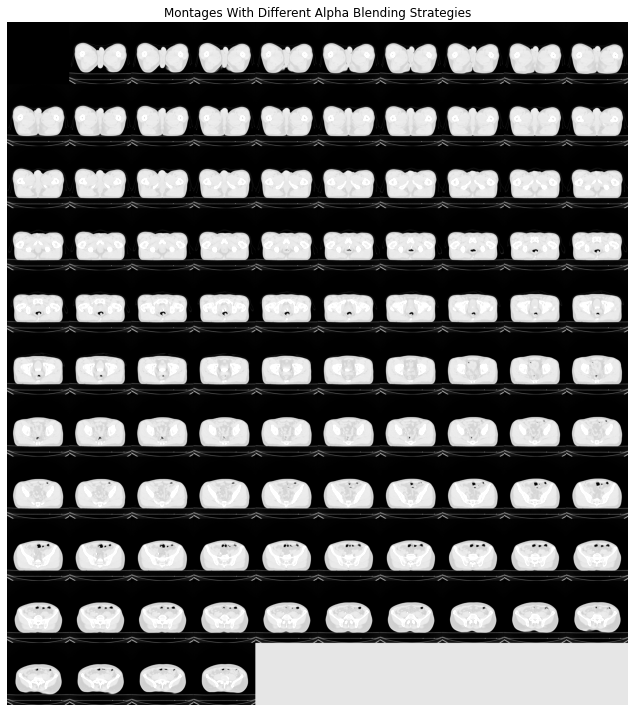

In [19]:
moving_image = sitk.Resample(moving_image, fixed_image)

# Hacimleri Karşılaştırma
images_list = [
               (alpha_blend(fixed_image, moving_image), 'alpha_blend_standard')]

all_montages = []
for img,img_name in images_list:
    num_slices = img.GetDepth()
    tile_w = int(np.sqrt(num_slices))
    tile_h = int(np.ceil(num_slices/tile_w))
    tile_image = sitk.Tile([img[:,:,i] for i in range(num_slices)], (tile_w, tile_h))
    all_montages.append(tile_image)

# AlphaBlendig Görüntüleme
gui.MultiImageDisplay(image_list = [sitk.JoinSeries(all_montages)],
                      title_list = ['Montages With Different Alpha Blending Strategies'],
                      figure_size=(13,10));

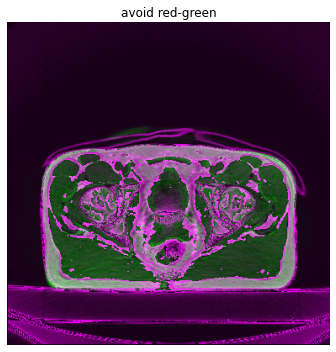

In [20]:
#Registration sonrası MR ve CT görüntü kısımlarını renklendirme
zeros = sitk.Image(fixed_image.GetSize(), moving_image.GetPixelID())
zeros.CopyInformation(fixed_image)

gui.MultiImageDisplay(image_list = [sitk.Cast(sitk.Compose(fixed_image, moving_image, fixed_image), sitk.sitkVectorUInt8)],
                      title_list= ['avoid red-green'],
                      figure_size=(8,5));

In [21]:
# LandMark Validasyon için ekstra Kütüphane İşlemleri
%matplotlib notebook
import registration_utilities as ru
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import gui

Fetching ct_T1.standard


<IPython.core.display.Javascript object>


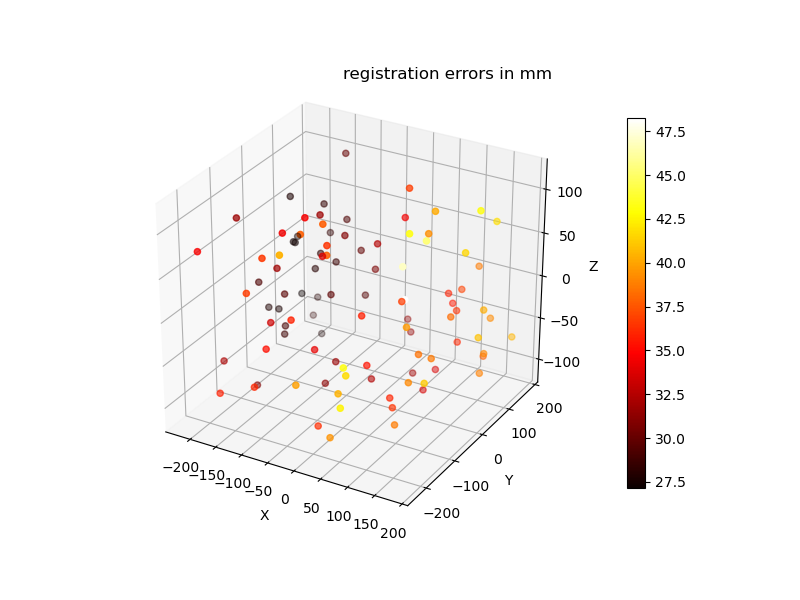

Before registration, errors (TRE) in millimeters, mean(std): 34.99(5.04), max: 48.25


In [22]:
#Landmark Validasyon İşlemleri (Otomatik Versiyon)

# ct_T1. standartları
fixed_fiducial_points, moving_fiducial_points = ru.load_RIRE_ground_truth(fdata("ct_T1.standard"))

        
# Landmark nokta koordinatları belirleme
fixed_fiducial_points_flat = [c for p in fixed_fiducial_points for c in p]        
moving_fiducial_points_flat = [c for p in moving_fiducial_points for c in p]
reference_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                             fixed_fiducial_points_flat, 
                                                             moving_fiducial_points_flat)

# Fixed ve moving image için referans veri kümesi oluşturma
fixed_points = ru.generate_random_pointset(image=fixed_image, num_points=100)
moving_points = [reference_transform.TransformPoint(p) for p in fixed_points]    

# Hataların hesaplanması ve grafik ile gösterilmesi
pre_errors_mean, pre_errors_std, _, pre_errors_max, pre_errors = ru.registration_errors(sitk.Euler3DTransform(), fixed_points, moving_points, display_errors=True)
print(f'Before registration, errors (TRE) in millimeters, mean(std): {pre_errors_mean:.2f}({pre_errors_std:.2f}), max: {pre_errors_max:.2f}')        

<IPython.core.display.Javascript object>


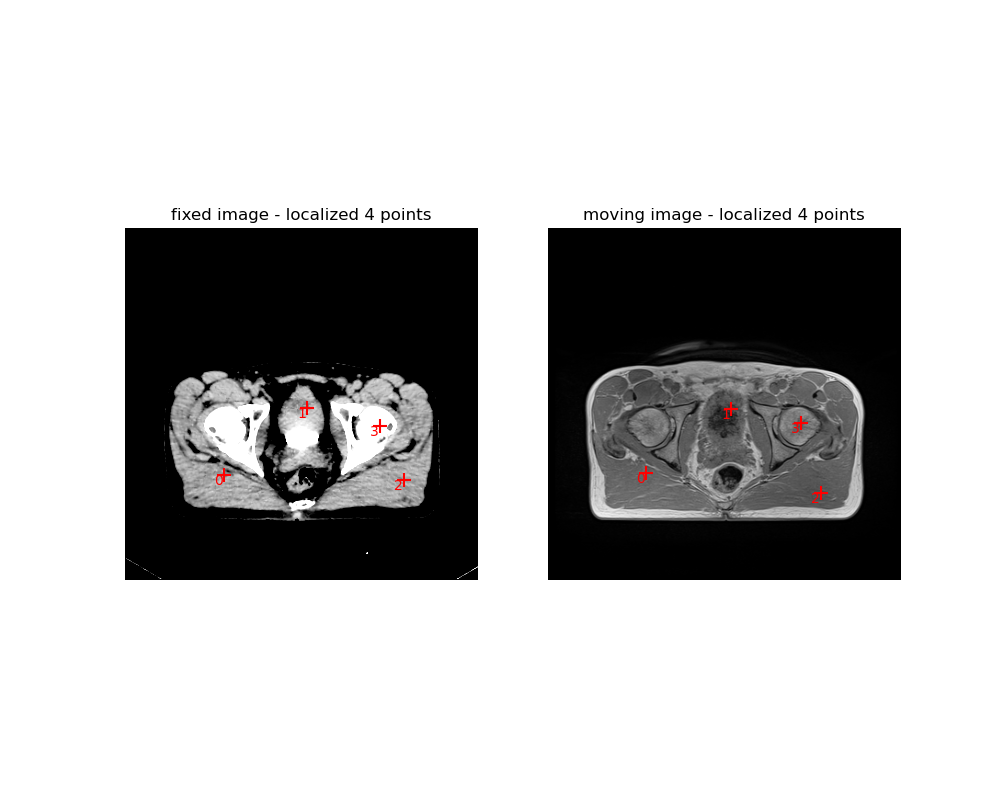

In [23]:
# Görüntü üzerinde karşılık değeri bulma
point_acquisition_interface = gui.RegistrationPointDataAquisition(fixed_image, moving_image, fixed_window_level=(150,20))

In [24]:
# Manuel verilen koordinatlar ile validasyon işlemi
fixed_image_points = [(156.48434676356158, 201.92274575468412, 68.0), 
                      (194.25413436597393, 98.55771047484492, 32.0),
                      (128.94523819661913, 96.18284152323203, 32.0)]
moving_image_points = [(141.46826904042848, 156.97653126727528, 48.0),
                       (113.70102381552435, 251.76553994455645, 8.0),
                       (180.69457220262115, 251.76553994455645, 8.0)]


<IPython.core.display.Javascript object>


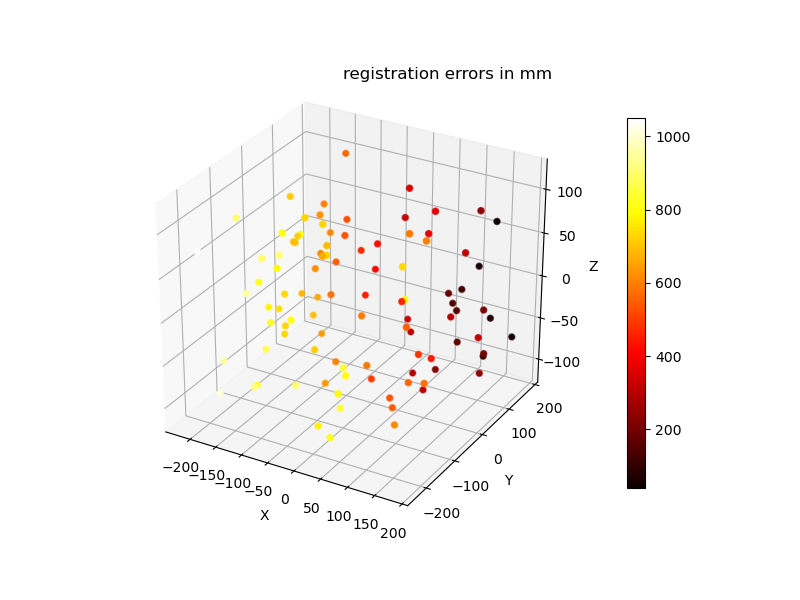

After registration (manual point localization), errors (TRE) in millimeters, mean(std): 573.37(247.49), max: 1049.40


In [25]:
fixed_image_points_flat = [c for p in fixed_image_points for c in p]        
moving_image_points_flat = [c for p in moving_image_points for c in p]
manual_localized_transformation = sitk.VersorRigid3DTransform(sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                         fixed_image_points_flat, 
                                                                         moving_image_points_flat))

manual_errors_mean, manual_errors_std, manual_errors_min, manual_errors_max,_ = \
    ru.registration_errors(manual_localized_transformation,
                           fixed_points, 
                           moving_points, 
                           display_errors=True)
print(f'After registration (manual point localization), errors (TRE) in millimeters, mean(std): {manual_errors_mean:.2f}({manual_errors_std:.2f}), max: {manual_errors_max:.2f}')

In [26]:
updated_moving_image_points = moving_image_points

<IPython.core.display.Javascript object>


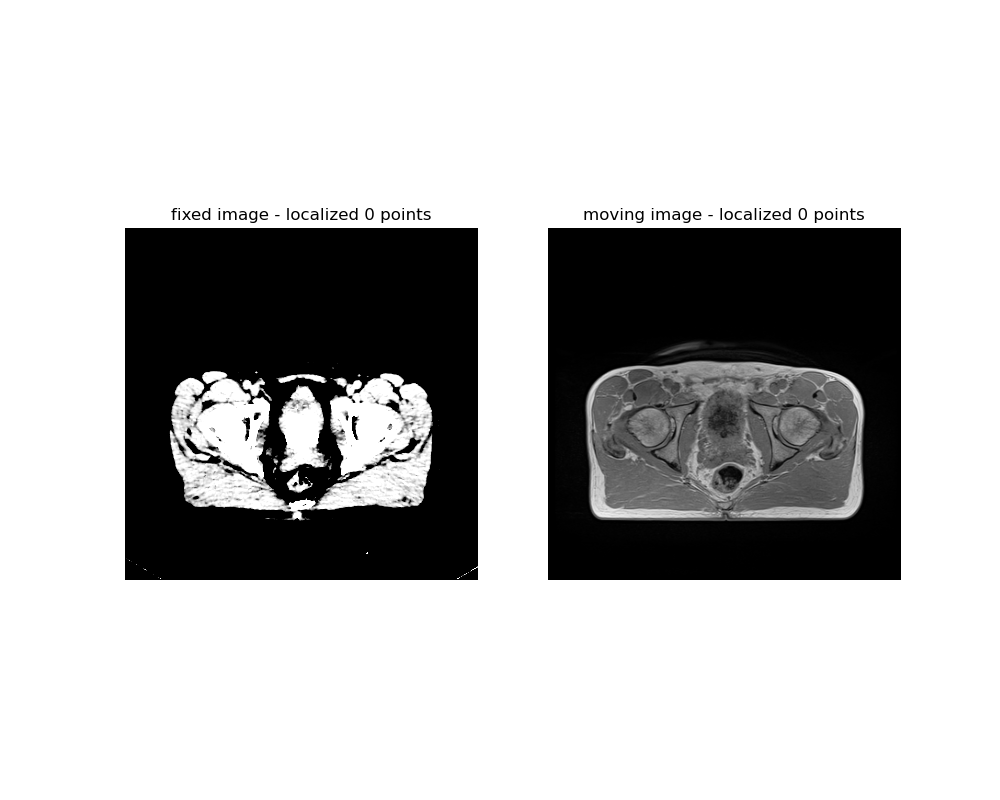

In [27]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, fixed_window_level=(50,10), known_transformation=manual_localized_transformation)